In [1]:
import os
import sys
sys.path.append(os.getcwd())
import torch
import argparse
from model.deeplab import *
from tqdm import tqdm
import json
from utils.metrics import Evaluator
from data import spacenet
from common import config
from torch.utils.data import DataLoader
import numpy as np
import cv2
import torchvision
import matplotlib.pyplot as plt
import torch.nn
from model.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
import pdb
from tensorboardX import SummaryWriter
from numpy import linalg as la

In [2]:
s = torch.load('statistics/Shanghai_dataset.pth')
v = torch.load('statistics/Vegas_dataset.pth')

#### Dataset: Shanghai

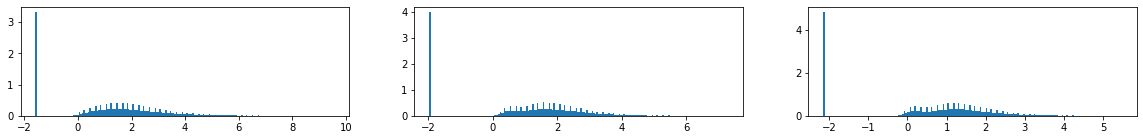

In [3]:
fig, axs = plt.subplots(1, 3, figsize = (20, 2))
axs[0].hist(s['R'], bins = 200, density = 1)
axs[1].hist(s['G'], bins = 200, density = 1)
axs[2].hist(s['B'], bins = 200, density = 1)
plt.show()



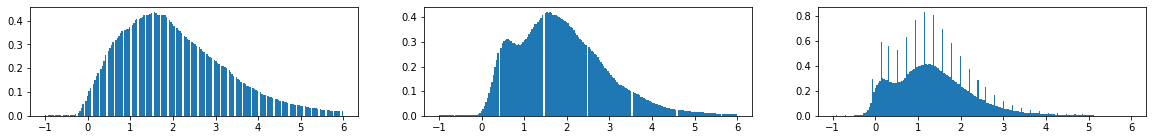

In [4]:
fig, axs = plt.subplots(1, 3, figsize = (20, 2))
axs[0].hist(s['R'], bins = 200, density = 1, range=(-1,6))
axs[1].hist(s['G'], bins = 200, density = 1, range=(-1,6))
axs[2].hist(s['B'], bins = 200, density = 1, range=(-1,6))
plt.show()

#### Dataset: Vegas

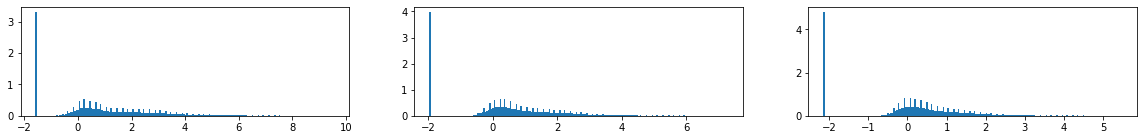

In [5]:
fig, axs = plt.subplots(1, 3, figsize = (20, 2))
axs[0].hist(v['R'], bins = 200, density = 1)
axs[1].hist(v['G'], bins = 200, density = 1)
axs[2].hist(v['B'], bins = 200, density = 1)
plt.show()

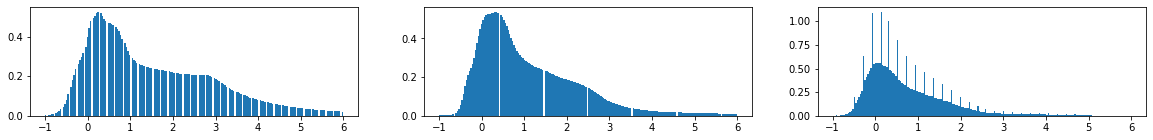

In [6]:
fig, axs = plt.subplots(1, 3, figsize = (20, 2))
axs[0].hist(v['R'], bins = 200, density = 1, range=(-1,6))
axs[1].hist(v['G'], bins = 200, density = 1, range=(-1,6))
axs[2].hist(v['B'], bins = 200, density = 1, range=(-1,6))
plt.show()

#### batch: Shanghai

In [9]:
# image_set = spacenet.Spacenet(city="Shanghai", split='train', img_root=config.img_root)
# image_loader = DataLoader(image_set, batch_size=config.batch_size, shuffle=False, num_workers=2, drop_last=True)
# for sample in image_loader:
#     image, target = sample['image'], sample['label']
#     image = image.permute(1, 0, 2, 3).reshape(3, -1)
    
#     fig, axs = plt.subplots(1, 3, figsize = (20, 2))
#     axs[0].hist(image[0], bins = 200, density = 1)
#     axs[1].hist(image[1], bins = 200, density = 1)
#     axs[2].hist(image[2], bins = 200, density = 1)
#     plt.show()
#     break

#### dataset: Shanghai -- mean & std

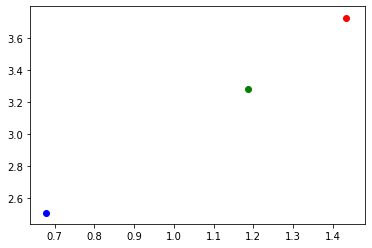

In [10]:
r_mean = torch.mean(s['R']).numpy()
r_var = torch.var(s['R']).numpy()
g_mean = torch.mean(s['G']).numpy()
g_var = torch.var(s['G']).numpy()
b_mean = torch.mean(s['B']).numpy()
b_var = torch.var(s['B']).numpy()
plt.scatter([r_mean], [r_var], c='r')
plt.scatter([g_mean], [g_var], c='g')
plt.scatter([b_mean], [b_var], c='b')
plt.show()

#### dataset: Vegas -- mean & std

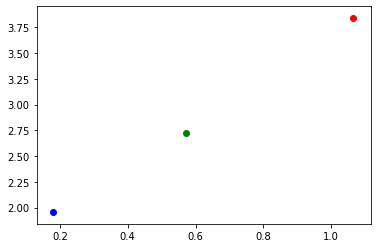

In [11]:
r_mean = torch.mean(v['R']).numpy()
r_var = torch.var(v['R']).numpy()
g_mean = torch.mean(v['G']).numpy()
g_var = torch.var(v['G']).numpy()
b_mean = torch.mean(v['B']).numpy()
b_var = torch.var(v['B']).numpy()
plt.scatter([r_mean], [r_var], c='r')
plt.scatter([g_mean], [g_var], c='g')
plt.scatter([b_mean], [b_var], c='b')
plt.show()

### 

#### Do coral on images

In [24]:
# # shanghai:source
# Cs = np.cov([s['R'].numpy(), s['G'].numpy(), s['B'].numpy()])
# # vegas:target
# Ct = np.cov([v['R'].numpy(), v['G'].numpy(), v['B'].numpy()])

In [3]:
# shanghai:target
Ct = np.cov([s['R'].numpy(), s['G'].numpy(), s['B'].numpy()])
# vegas:source
Cs = np.cov([v['R'].numpy(), v['G'].numpy(), v['B'].numpy()])

In [4]:
u_s,sigma_s,v_s = la.svd(Cs)
u_t,sigma_t,v_t = la.svd(Ct)

S_s = np.zeros((3,3))
S_t = np.zeros((3,3))
for i in range(3):
    S_s[i][i] = sigma_s[i]
    S_t[i][i] = sigma_t[i]

writening = u_t @ np.power(la.pinv(S_t), 0.5) @ v_t

recoloring = u_s @ np.power(S_s, 0.5) @ v_s

A_opt = writening @ recoloring

In [5]:
A_opt

array([[ 1.19546324,  0.20269166,  0.08016748],
       [ 0.0314609 ,  0.77317697, -0.13274298],
       [-0.26675047, -0.08562511,  0.93975941]])

array([[3.72101093, 3.40282906, 2.92207221],
       [3.40282906, 3.27940331, 2.84761136],
       [2.92207221, 2.84761136, 2.50993531]])

array([[3.8441858 , 3.15361248, 2.58764333],
       [3.15361248, 2.71979973, 2.27926664],
       [2.58764333, 2.27926664, 1.95574789]])